In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d mrinath/pneumonia

 98% 1.15G/1.17G [00:15<00:00, 184MB/s]
100% 1.17G/1.17G [00:15<00:00, 79.5MB/s]


In [4]:
import zipfile
zf = "/content/pneumonia.zip"
target_dir = "/content/dataset/cnn/pneumonia"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
train_path = '/content/dataset/cnn/pneumonia/folders/train'
test_path = '/content/dataset/cnn/pneumonia/folders/test'
valid_path = '/content/dataset/cnn/pneumonia/folders/valid'

In [7]:
batch_size = 19

img_height = 150
img_width = 150

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.4,shear_range=0.3,vertical_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [9]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)

Found 4883 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 349 images belonging to 2 classes.


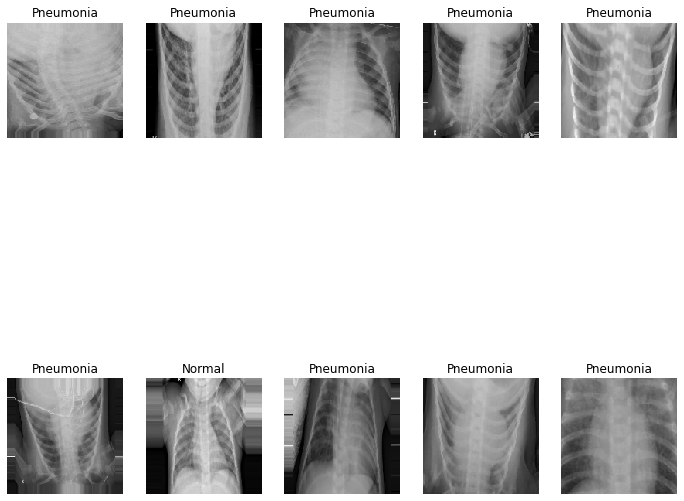

In [10]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, BatchNormalization, SeparableConv2D

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [12]:
model = Sequential()

model.add(SeparableConv2D(32,(3,3),input_shape=(img_width,img_height,3),kernel_initializer='he_normal',activation='swish'))
model.add(BatchNormalization())

model.add(SeparableConv2D(32,(3,3),kernel_initializer='he_normal',activation='swish'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(SeparableConv2D(64,(3,3),kernel_initializer='he_normal',activation='swish'))
model.add(BatchNormalization())

model.add(SeparableConv2D(64,(3,3),kernel_initializer='he_normal',activation='swish'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(SeparableConv2D(128,(3,3),kernel_initializer='he_normal',activation='swish'))
model.add(BatchNormalization())

model.add(SeparableConv2D(128,(3,3),kernel_initializer='he_normal',activation='swish'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(SeparableConv2D(256,(3,3),kernel_initializer='he_normal',activation='swish'))
model.add(BatchNormalization())

model.add(SeparableConv2D(256,(3,3),kernel_initializer='he_normal',activation='swish'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128,activation='relu'))

# model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))

model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(activation='sigmoid',units=1))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 148, 148, 32)      155       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 146, 146, 32)      1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 71, 71, 64)        2400      
_________________________________________________________________
batch_normalization_2 (Batch (None, 71, 71, 64)        2

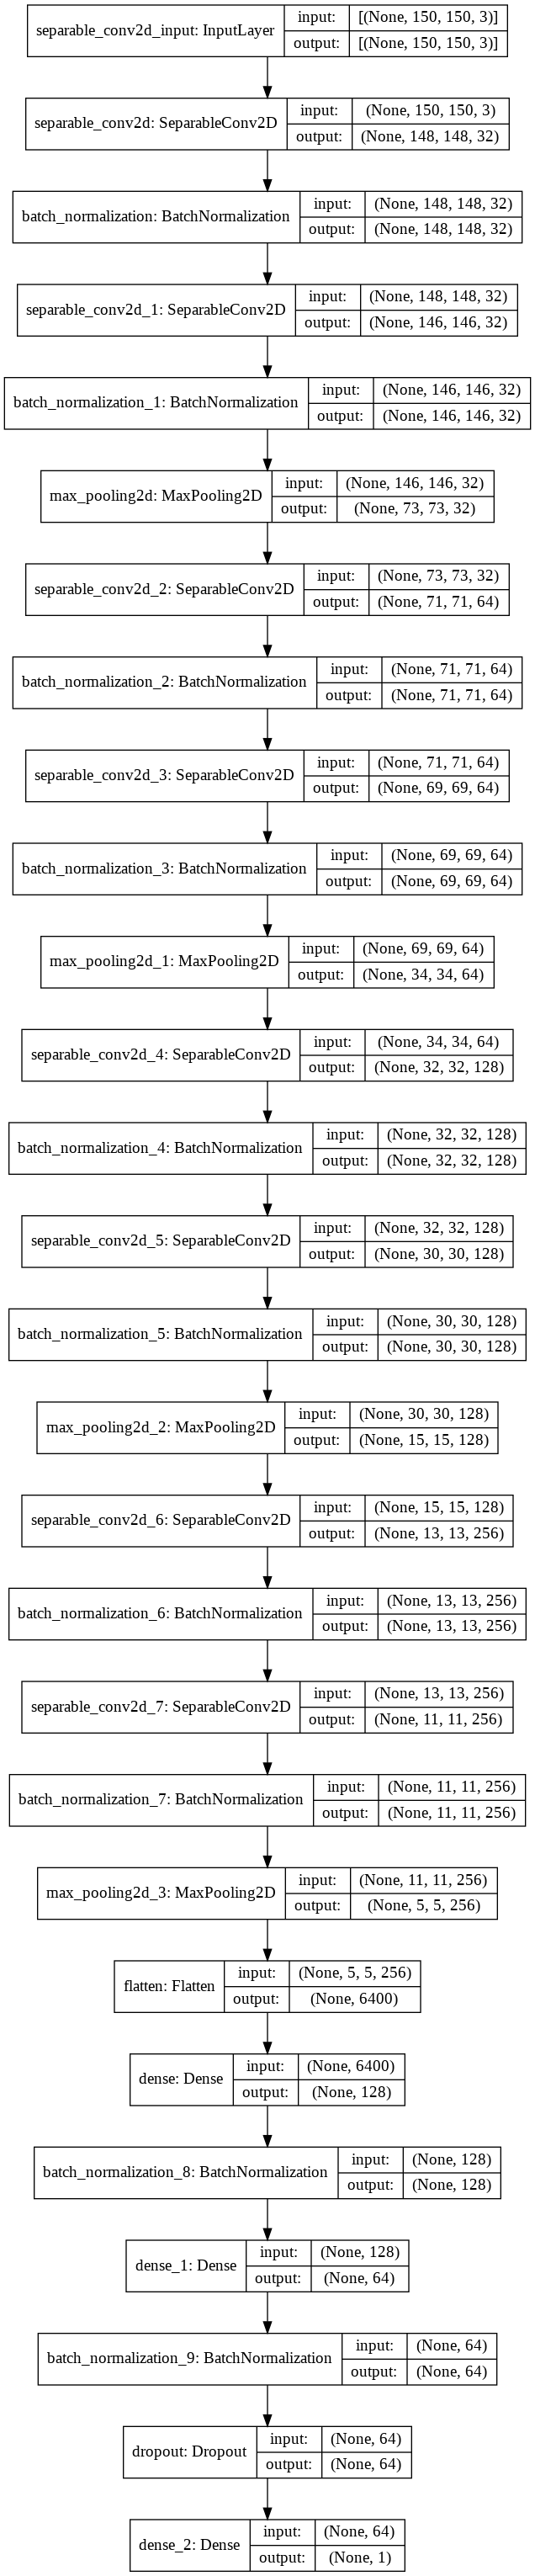

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [15]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
callbacks_list = [early,learning_rate_reduction]


In [16]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 2.0761054421768708, 1: 0.6586188292419747}


In [17]:
model.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512)

Epoch 1/25
257/257 [==============================] - 110s 305ms/step - loss: 0.5462 - accuracy: 0.7593 - val_loss: 0.8202 - val_accuracy: 0.5043
Epoch 2/25
257/257 [==============================] - 78s 302ms/step - loss: 0.3520 - accuracy: 0.8555 - val_loss: 1.6630 - val_accuracy: 0.5043
Epoch 3/25
257/257 [==============================] - 78s 303ms/step - loss: 0.3295 - accuracy: 0.8680 - val_loss: 0.4168 - val_accuracy: 0.8109
Epoch 4/25
257/257 [==============================] - 77s 301ms/step - loss: 0.3025 - accuracy: 0.8768 - val_loss: 0.5940 - val_accuracy: 0.7994
Epoch 5/25
257/257 [==============================] - 78s 303ms/step - loss: 0.2563 - accuracy: 0.8885 - val_loss: 0.4692 - val_accuracy: 0.8080
Epoch 6/25
257/257 [==============================] - 78s 303ms/step - loss: 0.2944 - accuracy: 0.8783 - val_loss: 0.2501 - val_accuracy: 0.9140
Epoch 7/25
257/257 [==============================] - 78s 302ms/step - loss: 0.2462 - accuracy: 0.9009 - val_loss: 0.2656 - val_a

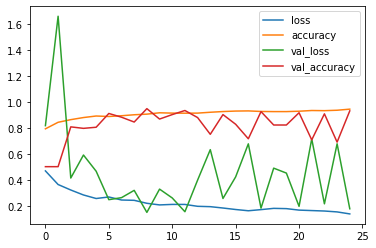

In [18]:
pd.DataFrame(model.history.history).plot()

In [19]:
test_accu = model.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

33/33 [==============================] - 6s 174ms/step - loss: 0.2084 - accuracy: 0.9183
The testing accuracy is -  91.82692170143127 %


In [20]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

y_bar = np.round(model.predict(test)).reshape(-1)
y_act = test.labels

##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.9182692307692307
ROC-AUC score:  0.9131038494890399
F1 score:  0.9346991037131882
Log Loss:  2.8229127981990385
